In [2]:
import pandas as pd
import numpy as np
import proj_acquire
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from tpot import TPOTClassifier



import warnings
warnings.filterwarnings("ignore")


# Prediciting Machine Failure

--- 

## Project Goal 

- The goal of this project is to create a reproducible  machine learning classification model to predict the whether or not a machine will fail, as well as what type of failure may occur 
- In order to achieve an accurate prediction, the project will identify key drivers of failures. This notebook serves as a way to understand why and how I made the prediction model.

---

## Project Description

-  Time is money during manufacturing. By prediciting whether or not a machine will fail and the type of failure, we are able to find the conditions which caused the failure. Predicting failure will eliminate downtime to repair broken equipment saving money from the machine parts and the labor required to do the repairs.

---

### Key Questions

1. How does RPM affect machine failure?

2. How does toque affect machine failure?

3. How does processing temperatures affect machine failures?

4. Does tool wear affect machine failure?

5. Does air temperature affect machine failure?

In [3]:
#Bringing in the data set
df = proj_acquire.prep_maint()

To prep the data I renamed all the columns to be easier to read and work with. I also renamed the target variable to machine failure.
I encoded the type of machine to have a column for each type. This was I could use it in the model.
There were no nulls to fill or drop.
The data types were good to go and do not need to be changed
I kept failure_type under one column in order to do multiclassification later in report


In [4]:
# Checking to see if it was all brought in the right way and prepped correctly
df.head()

,air_temp,process_temp,rpm,torque,tool_wear,machine_failure,failure_type,H,L,M
0,298.1,308.6,1551,42.8,0,0,No Failure,0,0,1
1,298.2,308.7,1408,46.3,3,0,No Failure,0,1,0
2,298.1,308.5,1498,49.4,5,0,No Failure,0,1,0
3,298.2,308.6,1433,39.5,7,0,No Failure,0,1,0
4,298.2,308.7,1408,40.0,9,0,No Failure,0,1,0


In [5]:
# checking the data types
df.dtypes

air_temp           float64
process_temp       float64
rpm                  int64
torque             float64
tool_wear            int64
machine_failure      int64
failure_type        object
H                    uint8
L                    uint8
M                    uint8
dtype: object

All the data types look good to go as well. 

In [6]:
# checking for nulls
df.isnull().sum()

air_temp           0
process_temp       0
rpm                0
torque             0
tool_wear          0
machine_failure    0
failure_type       0
H                  0
L                  0
M                  0
dtype: int64

No null values to be dropped to imputed as addressed earlier

In [7]:
# spltting the data into three parts to ensure no leakage
train, validate, test = proj_acquire.split_maint_fail_type(df)

In [8]:
# Check in that shape to see if it worked
train.shape, validate.shape, test.shape

((6400, 10), (1600, 10), (2000, 10))

#
---
## Exploration phase

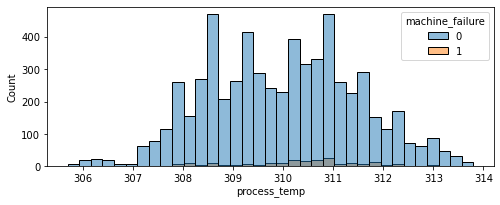

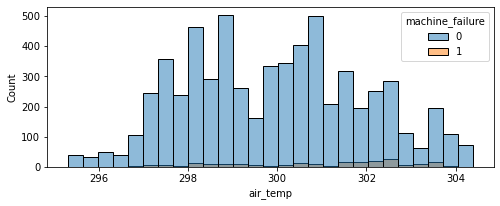

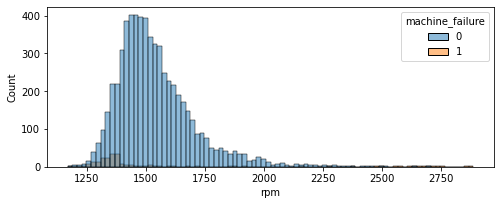

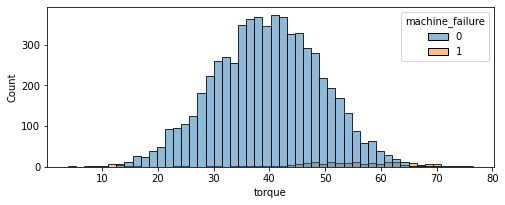

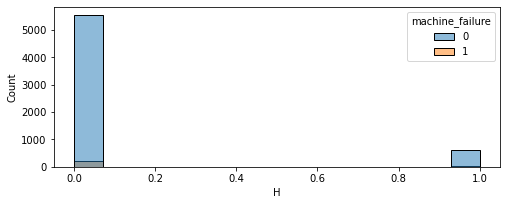

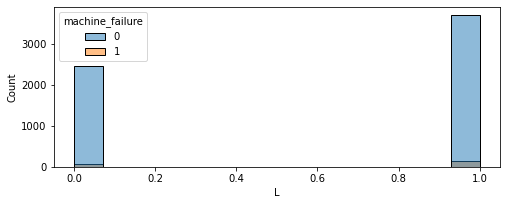

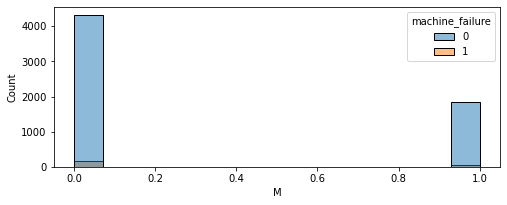

In [9]:
# making an interative list of graphs to compare each of the features against binary machine failure
cols= ['process_temp', 'air_temp', 'rpm', 'torque', 'H', 'L', 'M']
m=1
for col in cols:
  plt.figure(figsize=(8,10))
  plt.subplot(3,1,m)
  sns.histplot(data= train, x = col, hue=train.machine_failure)
  plt.show()

This was to vizualize all failures against the features 
* Processing temp fails the most around 310-312 degrees
* Air temp failure is more spread out and the most range from 298 - 303
* The bulk of failure from RPMS is in the lower range < 1500 and comes back at > 2250
* Torque sees more failures when > 50
* L type is most common and has most failures
* M is second most common 
* H is least common with undetectable visual failures.

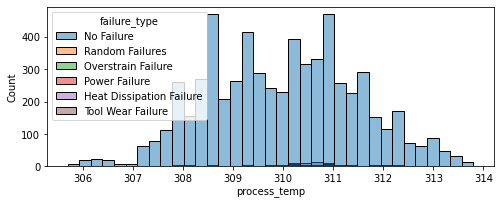

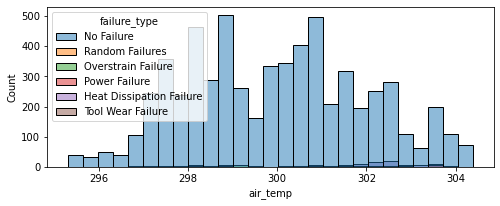

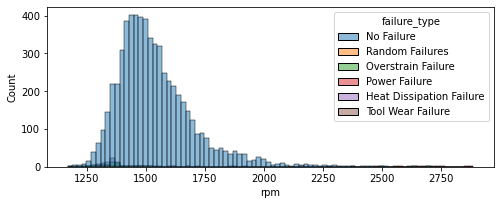

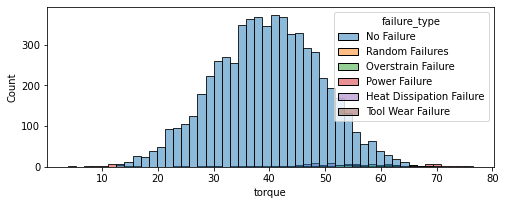

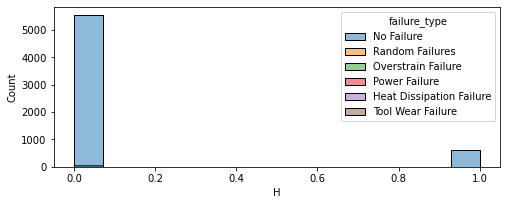

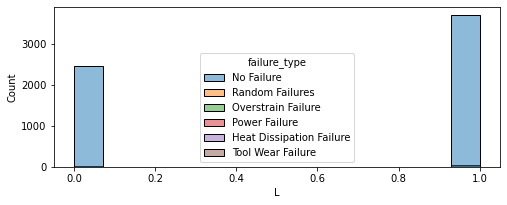

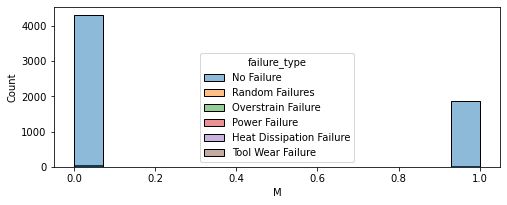

In [10]:

cols= ['process_temp', 'air_temp', 'rpm', 'torque', 'H', 'L', 'M']
m=1
for col in cols:
  plt.figure(figsize=(8,10))
  plt.subplot(3,1,m)
  sns.histplot(data= train, x = col, hue=train.failure_type)
  plt.show()

The features are normally distributed
Accounting for the different types of failures is hard to see because the data is very imbalanced and hard to read each failure type. 
Below I will focus on whether or not a machine will fail. 

In [11]:
# Checking out train to see how many values of each failure I have versus non failure
train.failure_type.value_counts()

No Failure                  6178
Heat Dissipation Failure      72
Power Failure                 61
Overstrain Failure            49
Tool Wear Failure             29
Random Failures               11
Name: failure_type, dtype: int64

The data is severly imbalanced to non-failure. To combat this, I will use SMOTE to impute synthetic values on the train data to train a better model for unseen data.

<AxesSubplot:>

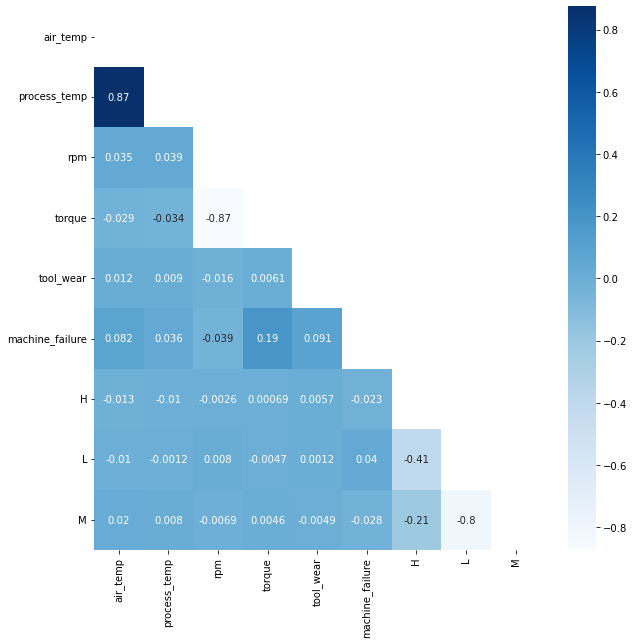

In [12]:
# making a correlation table using spearman becuase data is not normally distributed
correlation_table = train.corr()

# Declaring a size for the heatmap and making heatmap to see the correlations between all variables in the dataset
plt.figure(figsize= (10,10))
sns.heatmap(correlation_table, cmap='Blues', annot = True, mask = np.triu(correlation_table))

checking the correlation it seems that both temperatures are highly correlated. Rpm and torque are also highly correlated. In a different explore file, I tried the models where I dropped one of the correlated variables and another where I made ratios. The models performed worse and I came back to work on original data set. Please look at explore 2 for those experiments

Question 1: How does RPM affect machine failure?

- For this I wanted to put the rpms into bins to better showcase how it affects machine failure

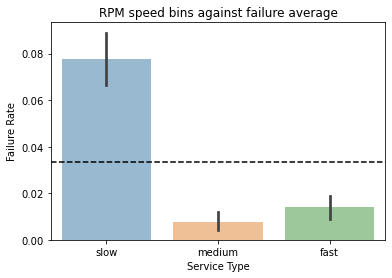

In [13]:
# Bringing in the function to bin rpm data in order to better visualize how rpm affects machine failure
proj_acquire.rpm_bin(train)

The chart shows that lower rpms experience the most failures by a wide margin.

Ho - Rpm is independent from machine failure
Ha - Rpm is dependent on machine failure

In [14]:
# Setting up an ANOVA test to determine statistical significance
slow = train[train['rpm_bin'] == 'slow'].machine_failure
jog = train[train['rpm_bin'] == 'medium'].machine_failure
fast = train[train['rpm_bin'] == 'fast'].machine_failure
# Set alpha to a 99% confidence level
alpha = 0.01
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(slow, jog, fast)
if p < alpha:
    print('We reject the null and the variable is statistically significant')
else:
    print('We fail to reject the null and it is not statistically significant')

We reject the null and the variable is statistically significant


Question 2: How does toque affect machine failure?
 
- I once again binned that data for easier vizualization

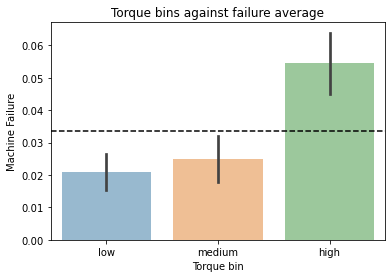

In [15]:
# Bringing in the function to bin the toque data to better vizualize and test statistically. see proj_acquire.py for the full code
proj_acquire.toque_bin(train)

Torque appears to be opposite of rpm and experiences more failure on the high end of the range. Again the failure is by a large margin

Ho - Machine failure is independent of torque
Ha - Machine failure is dependent on torque

In [16]:
# Setting up an ANOVA test to test for statistical significance
low = train[train['torque_bin'] == 'low'].machine_failure
medium = train[train['torque_bin'] == 'medium'].machine_failure
high = train[train['torque_bin'] == 'high'].machine_failure
# Set alpha for a 99% confidence
alpha = 0.01
# Comparing mean of 3 independent samples against a p value
t, p = stats.f_oneway(low, medium, high)
if p < alpha:
    print('We reject the null and the variable is statistically significant')
else:
    print('We fail to reject the null and it is not statistically significant')

We reject the null and the variable is statistically significant


Question 3: How does processing temperatures affect machine failures?

- Data is binned for easy viewing

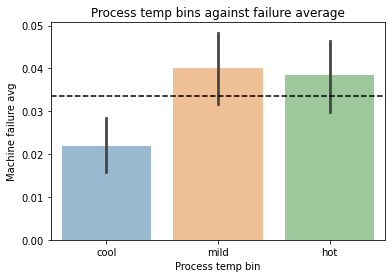

In [17]:
# Bringing in the function to bin the temperatures to graph and compare against overall failure
proj_acquire.process_bin(train)

There is a difference in failure rates amongst the bins. This has a wider band of failure with only the lower temp range no experiencing large number of failures

Ho - Machine failure is indepenent of process temps
Ha - Machine failure is dependent on process temps

In [18]:
# Setting up the variables for the annova test
cold = train[train['process_temp_bin'] == 'cool'].machine_failure
warm = train[train['process_temp_bin'] == 'mild'].machine_failure
hotter = train[train['process_temp_bin'] == 'hot'].machine_failure
# Set alpha with confidence of 99%
alpha = 0.01
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cold, warm, hotter)
if p < alpha:
    print('We reject the null and the variable is statistically significant')
else:
    print('We fail to reject the null and it is not statistically significant')

We reject the null and the variable is statistically significant


Question 4: Does tool wear affect machine failure?

- binned for easy viewing

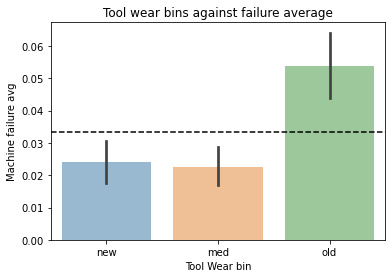

In [19]:
#Bringing in the function to bin the tool wear data to better graph against machine failure
proj_acquire.tool_bin(train)

The older tools with more wear show much higher failure rates than those not as old. 

Ho - Machine failure is independent of tool wear
Ha- Machine failure is dependent of tool wear

In [20]:
# Setting up the variables to preform an Annova test
new = train[train['tool_wear_bin'] == 'new'].machine_failure
med = train[train['tool_wear_bin'] == 'med'].machine_failure
old = train[train['tool_wear_bin'] == 'old'].machine_failure
# Set alpha to 99%
alpha = 0.01
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(new, med, old)
if p < alpha:
    print('We reject the null and the variable is statistically significant')
else:
    print('We fail to reject the null and it is not statistically significant')

We reject the null and the variable is statistically significant


Question 5: Does air temperature affect machine failure?

- binned for easy viewing

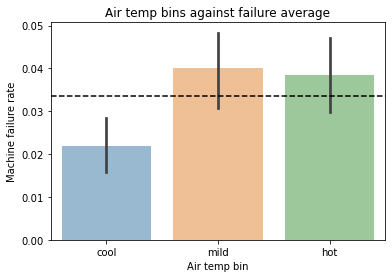

In [21]:
# Bringing in the function to bin the air temps to better graph against machine failure
proj_acquire.air_bin(train)

Machine failures appear to happen in the mild to hot temperature zones. Cool temps has less affect on failures

Ho - Machine failure is independent on air temps
Ha - Machine failure is dependent on air temps

In [22]:
# Setting up the variables for the Annova test
cool = train[train['air_temp_bin'] == 'cool'].machine_failure
mild = train[train['air_temp_bin'] == 'mild'].machine_failure
hot = train[train['air_temp_bin'] == 'hot'].machine_failure
# Set alpha to be 99% confidence
alpha = 0.01
# Comparing mean of 3 independent samples
t, p = stats.f_oneway(cool, mild, hot)
if p < alpha:
    print('We reject the null and the variable is statistically significant')
else:
    print('We fail to reject the null and it is not statistically significant')

We reject the null and the variable is statistically significant


In [23]:
# I will not use the bins as in the previous explore notebooks, RFE did not select any of the bins
train = proj_acquire.drop_bins(train)

In [24]:
# checking to see if bins dropped 
train.head()

,air_temp,process_temp,rpm,torque,tool_wear,machine_failure,failure_type,H,L,M
5884,301.3,311.1,1438,43.0,137,0,No Failure,0,0,1
6928,301.1,311.7,1816,24.5,7,0,No Failure,0,1,0
4514,302.4,310.3,1479,36.2,115,0,No Failure,0,1,0
9532,299.2,310.5,1384,48.7,93,0,No Failure,0,1,0
6607,301.5,310.5,1556,39.1,48,0,No Failure,0,1,0


## Exploration Summary
- Each of the variables explored show statistical significance. 
- Air and process temperatures show the most variety within overall failures. 
- Rpm shows failure in the low range of values
- Tool wear and Torque show failure in the higher ranges compared to rpm.
- The multicolinearity is ok becuase of the use of classification models. I explore handing multicolinearity in different explore notebooks
- The bins were dropped as I explored those as well in different notebook and selected RFE did not choose a single bin.
- I used anova tests for each of the bins becuase there were three bins each
---
## Modeling phase in which the first model will be an overal predictor of if a machine will fail or not fail. 
- I will be using recall score to determine the how accurately the model find true positives or those that failed and were predicted to fail
- The first phase to determine the binary outcome of whether the machine will fail or not fail
- The second model will determine the type of failure the machine occured. 

In [24]:
# Setting the baseline
baseline = 1 - train.machine_failure.mean()
baseline

0.9665625

Although I brought in baseline, I will not be using it to assess my models performance. The baseline does not have a recall score or the true positives that I am looking to maximize. 

In [25]:
# Splitting the x and y variables for the model for all three subsets
x_train = train.drop(columns = ['machine_failure', 'failure_type'])
x_validate = validate.drop(columns = ['machine_failure', 'failure_type'])
x_test = test.drop(columns = ['machine_failure', 'failure_type'])

y_train = train['machine_failure']
y_validate = validate['machine_failure']
y_test = test['machine_failure']

Because the data is so imbalanced I am using SMOTE to help generate more data and oversample to help models preform better. This increased the size of my training data from 6400 to 12370. Offering the model more data to train on.

In [26]:
# Bringing in and assigning smote
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)


In [27]:
# checking the before and after shapes
x_train.shape, x_res.shape

((6400, 8), (12372, 8))

In [28]:
# Bringing in and assigning the model to see the classification reports
proj_acquire.decision_tree(x_res, y_res, x_validate, y_validate)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6186
           1       0.88      0.96      0.92      6186

    accuracy                           0.92     12372
   macro avg       0.92      0.92      0.92     12372
weighted avg       0.92      0.92      0.92     12372

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1542
           1       0.18      0.81      0.29        58

    accuracy                           0.86      1600
   macro avg       0.58      0.83      0.61      1600
weighted avg       0.96      0.86      0.90      1600



The top is the train report and the bottom is validate's report
The modeled did better on the train due. Decision tree had an 81% recall rate which means guessed actual failures correctly and an overall accuracy of 86%.

In [29]:
# Bringing in and assigning the model to see the classification reports
proj_acquire.random_forest(x_res, y_res, x_validate, y_validate)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      6186
           1       0.91      0.92      0.91      6186

    accuracy                           0.91     12372
   macro avg       0.91      0.91      0.91     12372
weighted avg       0.91      0.91      0.91     12372

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1542
           1       0.23      0.76      0.36        58

    accuracy                           0.90      1600
   macro avg       0.61      0.83      0.65      1600
weighted avg       0.96      0.90      0.93      1600



The top is the train report and the bottom is validate's report
Random Forest had a good accuracy beating baseline, but the recall rate was lower than that of regular decision trees. I will not move forward with random forest

In [30]:
# Bringing in and assigning the model to see the classification reports
proj_acquire.k_neighbors(x_res, y_res, x_validate, y_validate)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6186
           1       1.00      0.98      0.99      6186

    accuracy                           0.99     12372
   macro avg       0.99      0.99      0.99     12372
weighted avg       0.99      0.99      0.99     12372

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1542
           1       0.23      0.47      0.31        58

    accuracy                           0.92      1600
   macro avg       0.60      0.70      0.63      1600
weighted avg       0.95      0.92      0.94      1600



The top is the train report and the bottom is validate's report
K neighbors performed well in accuracy but the recall rate was terrible. Almost half of what the decisions trees rate was. I will not be moving forward with k neighbors. 

In [31]:
proj_acquire.svm_model(x_res, y_res, x_validate, y_validate)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6186
           1       0.90      0.86      0.88      6186

    accuracy                           0.88     12372
   macro avg       0.88      0.88      0.88     12372
weighted avg       0.88      0.88      0.88     12372

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1542
           1       0.20      0.67      0.30        58

    accuracy                           0.89      1600
   macro avg       0.59      0.78      0.62      1600
weighted avg       0.96      0.89      0.92      1600



The top is the train report and the bottom is validate's report

The SVM model did not do terrible on the accuracy but with a 67% recall rate, I will not be moving forward with the SVM model. 

In [32]:
proj_acquire.xg_model(x_res, y_res, x_validate, y_validate)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6186
           1       1.00      1.00      1.00      6186

    accuracy                           1.00     12372
   macro avg       1.00      1.00      1.00     12372
weighted avg       1.00      1.00      1.00     12372

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1542
           1       0.60      0.76      0.67        58

    accuracy                           0.97      1600
   macro avg       0.80      0.87      0.83      1600
weighted avg       0.98      0.97      0.97      1600



The top is the train report and the bottom is validate's report
Great accuracy on XGBoost classifier but the recall was poor. For that reason, I will not be moving forward with XGboost

#
---
### Running the best classification model, Decision Tree, on test set

In [31]:
# Bringing in and assigning the model to see the classification reports
proj_acquire.decision_tree(x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6186
           1       0.88      0.96      0.92      6186

    accuracy                           0.92     12372
   macro avg       0.92      0.92      0.92     12372
weighted avg       0.92      0.92      0.92     12372

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1933
           1       0.19      0.88      0.32        67

    accuracy                           0.87      2000
   macro avg       0.59      0.88      0.62      2000
weighted avg       0.97      0.87      0.91      2000



After running the model on test, the results were better than on validate. The recall rate of finding and detecting failures is 88% with an overall accuracy of 87%. However, the model did not beat the baseline accuracy.

#
---
## Multiclassification model

In [33]:
# Splitting the x and y variables for the model for all three subsets
x_train2 = train.drop(columns = ['machine_failure', 'failure_type'])
x_validate2 = validate.drop(columns = ['machine_failure', 'failure_type'])
x_test2 = test.drop(columns = ['machine_failure', 'failure_type'])

y_train2 = train['failure_type']
y_validate2 = validate['failure_type']
y_test2 = test['failure_type']

In [34]:
# using smote for the multiclass model 
sm = SMOTE(random_state=42)
x_res2, y_res2 = sm.fit_resample(x_train2, y_train2)

In [35]:
#Bringing in function for the model
proj_acquire.decision_tree(x_res2, y_res2, x_validate2, y_validate2)

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.84      0.93      0.88      6178
              No Failure       0.94      0.05      0.10      6178
      Overstrain Failure       0.89      0.94      0.92      6178
           Power Failure       0.96      0.92      0.94      6178
         Random Failures       0.54      0.98      0.70      6178
       Tool Wear Failure       0.91      0.94      0.93      6178

                accuracy                           0.79     37068
               macro avg       0.85      0.79      0.74     37068
            weighted avg       0.85      0.79      0.74     37068

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.10      0.83      0.17        18
              No Failure       0.99      0.05      0.09      1544
      Overstrain Failure       0.28      0.92      0.43        13
           Power Failure       0.31      0.73      0.44        15
      

The top is the train report and the bottom is validate's report
The precision on validate is impressive at 99% on the no failures which is true negatives. It performs well in recall for all types of failures with the worst being 73% for power failures, but the best 100% for random failures. Overall recall score of 73%

In [36]:
#Bringing in function for the model
proj_acquire.random_forest(x_res2, y_res2, x_validate2, y_validate2)

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.80      0.96      0.87      6178
              No Failure       0.95      0.66      0.78      6178
      Overstrain Failure       0.89      0.96      0.92      6178
           Power Failure       0.96      0.92      0.94      6178
         Random Failures       0.77      0.78      0.78      6178
       Tool Wear Failure       0.91      0.97      0.94      6178

                accuracy                           0.87     37068
               macro avg       0.88      0.87      0.87     37068
            weighted avg       0.88      0.87      0.87     37068

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.20      0.78      0.31        18
              No Failure       1.00      0.66      0.79      1544
      Overstrain Failure       0.34      1.00      0.51        13
           Power Failure       0.22      0.73      0.34        15
      

The top is the train report and the bottom is validate's report
No failure precision was 100% however the recalls did not perform as well for the recalls rates as the decision tree did. 

In [37]:
#Bringing in function for the model

proj_acquire.k_neighbors(x_res2, y_res2, x_validate2, y_validate2)

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.96      1.00      0.98      6178
              No Failure       0.99      0.96      0.98      6178
      Overstrain Failure       1.00      1.00      1.00      6178
           Power Failure       1.00      1.00      1.00      6178
         Random Failures       1.00      1.00      1.00      6178
       Tool Wear Failure       1.00      1.00      1.00      6178

                accuracy                           0.99     37068
               macro avg       0.99      0.99      0.99     37068
            weighted avg       0.99      0.99      0.99     37068

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.09      0.56      0.16        18
              No Failure       0.99      0.81      0.89      1544
      Overstrain Failure       0.45      0.69      0.55        13
           Power Failure       0.33      0.60      0.43        15
      

The top is the train report and the bottom is validate's report
The results are similar to random forest, except with even worse recall rates. This might be improved if I were to scale the data. If time permits, I will try a scaled version to see how it performs. 

Performing KNN with scaled data can be found in my explore notebooks.

In [38]:
# Encoding the type of failure to pass thru XGBoost
le = LabelEncoder()
y_res2 = le.fit_transform(y_res2)
y_validate2 = le.fit_transform(y_validate2)
y_test2 = le.fit_transform(y_test2)

In [39]:
# proj_acquire.svm_model(x_res2, y_res2, x_validate2, y_validate2)

The SVM model did not perforom on the multiclassification part. It will not be included

In [40]:
proj_acquire.xg_model(x_res2, y_res2, x_validate2, y_validate2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6178
           1       1.00      1.00      1.00      6178
           2       1.00      1.00      1.00      6178
           3       1.00      1.00      1.00      6178
           4       1.00      1.00      1.00      6178
           5       1.00      1.00      1.00      6178

    accuracy                           1.00     37068
   macro avg       1.00      1.00      1.00     37068
weighted avg       1.00      1.00      1.00     37068

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       0.99      0.98      0.99      1544
           2       0.71      0.92      0.80        13
           3       0.74      0.93      0.82        15
           4       0.00      0.00      0.00         3
           5       0.07      0.14      0.10         7

    accuracy                           0.97      1600
   macro avg       0.57

The top is the train report and the bottom is validate's report
The metrics look good for xgboost. I missed all the random failues but is only that only accounts for 3 observations. The overall rate including the missed random failures is 66%

The top two performing models for both the multiclassification and regular classification were Decision Tree and XGBoost Classifier. The decision tree performed slight better in over recall with a 73% compared to XGBoosts 66%. However XG has a 97% accuracy compared to just 7% of decisions tree, due to the extreme difference in accuracy I will be going with XGBoost for the test. 

In [39]:
proj_acquire.xg_model(x_res2, y_res2, x_test2, y_test2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6178
           1       1.00      1.00      1.00      6178
           2       1.00      1.00      1.00      6178
           3       1.00      1.00      1.00      6178
           4       1.00      1.00      1.00      6178
           5       1.00      1.00      1.00      6178

    accuracy                           1.00     37068
   macro avg       1.00      1.00      1.00     37068
weighted avg       1.00      1.00      1.00     37068

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.99      0.98      0.99      1930
           2       0.67      0.88      0.76        16
           3       0.70      1.00      0.83        19
           4       0.00      0.00      0.00         4
           5       0.14      0.33      0.19         9

    accuracy                           0.97      2000
   macro avg       0.57

Performing the XG Boost on the test set resulted in slightly better performance than on validate. The model struggled with random failures which is number 4 on the encoder and tool wear failures number 5. The overall accuracy on recall is 69% with an overall of 97% which would match or beat baseline.

# Summary
* The best classification model for fail or not fail is the Decision Tree Classifier. The modele did better on the train due. Decision tree had an 81% recall rate which means guessed actual failures correctly and an overall accuracy of 86%.
* The top two performing models for both the multiclassification and regular classification were Decision Tree and XGBoost Classifier. The decision tree performed slight better in over recall with a 73% compared to XGBoosts 66%. However XG has a 97% accuracy compared to just 7% of decisions tree, due to the extreme difference in accuracy I will be going with XGBoost for the test. 
* Recall proved to be lower than overall accuracy. However, if I were to use accuracy for the baseline, I would be able to beat baseline by roughly 2%
* After running the models on test they slightly beat validate. Since there is no recall for 

---
# Recommendations
* Gain additional information from the machines such as time, so that we can predict when a tool might fail 
* Try to use a regression for the binary classification to see how well that might perform.
---
# Next Steps
* Build a model pipeline to predict if it would fail and then what type of failure more accurately
* Work if machines to find more features to add to model
* Proof of concecpt - can continue to build and work on the model. 

#
---
---
---
---
---

 This is an extra bonus to see how an automated ML Pipeline generator would preform. It ended up being worse and I did not move forward with it. 

### Trying out Tpot to create ml pipepline

In [15]:
tpot = TPOTClassifier(generations=5, verbosity=2)

tpot.fit(x_res2, y_res2)

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9947663993048614

Generation 2 - Current best internal CV score: 0.9947663993048614

Generation 3 - Current best internal CV score: 0.9950631352099061

Generation 4 - Current best internal CV score: 0.9967087725756534

Generation 5 - Current best internal CV score: 0.9967087725756534

Best pipeline: MLPClassifier(ExtraTreesClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=5, min_samples_split=9, n_estimators=100), alpha=0.0001, learning_rate_init=0.01)


TPOTClassifier(generations=5, verbosity=2)

In [22]:
print(tpot.score(x_validate2, y_validate2))

0.978125


In [26]:
# Making a prediction on validate in order to make 
y_val_pre = tpot.predict(x_validate2)
#print validate report
print(classification_report(y_validate2, y_val_pre))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.98      1.00      0.99      1544
           2       0.77      0.77      0.77        13
           3       0.60      0.40      0.48        15
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         7

    accuracy                           0.98      1600
   macro avg       0.55      0.47      0.50      1600
weighted avg       0.97      0.98      0.97      1600



In [17]:
#Export the result
tpot.export('tpot_ml_pipeline.py')


Tpot resulted in this pipeline the best. This did have the best accuracy amongst validate but the recal did poorly. 


ExTree = MLPClassifier(ExtraTreesClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=5, min_samples_split=9, n_estimators=100), alpha=0.0001, learning_rate_init=0.01)


In [ ]:
# ExTree = MLPClassifier(ExtraTreesClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=5, min_samples_split=9, n_estimators=100), alpha=0.0001, learning_rate_init=0.01)
